In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv

In [ ]:
# Get the data
!wget http://www.benjymarks.com/alert/before.png # This downloads the image we are going to use
!wget http://www.benjymarks.com/alert/after.png # This downloads the image we are going to use

F = plt.imread('before.png')
G = plt.imread('after.png')
F_gray = rgb_to_hsv(F)[:,:,2]
G_gray = rgb_to_hsv(G)[:,:,2]
F_gray_cropped = F_gray[200:,300:1600]
G_gray_cropped = G_gray[200:,300:1600]

--2022-09-29 12:52:13--  http://www.benjymarks.com/alert/before.png
Resolving www.benjymarks.com (www.benjymarks.com)... 65.254.227.224
Connecting to www.benjymarks.com (www.benjymarks.com)|65.254.227.224|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2626460 (2.5M) [image/png]
Saving to: ‘before.png’

before.png          100%[===================>]   2.50M  11.3MB/s    in 0.2s    

2022-09-29 12:52:13 (11.3 MB/s) - ‘before.png’ saved [2626460/2626460]

--2022-09-29 12:52:13--  http://www.benjymarks.com/alert/after.png
Resolving www.benjymarks.com (www.benjymarks.com)... 65.254.227.224
Connecting to www.benjymarks.com (www.benjymarks.com)|65.254.227.224|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627113 (2.5M) [image/png]
Saving to: ‘after.png’

after.png           100%[===================>]   2.50M  11.3MB/s    in 0.2s    

2022-09-29 12:52:14 (11.3 MB/s) - ‘after.png’ saved [2627113/2627113]



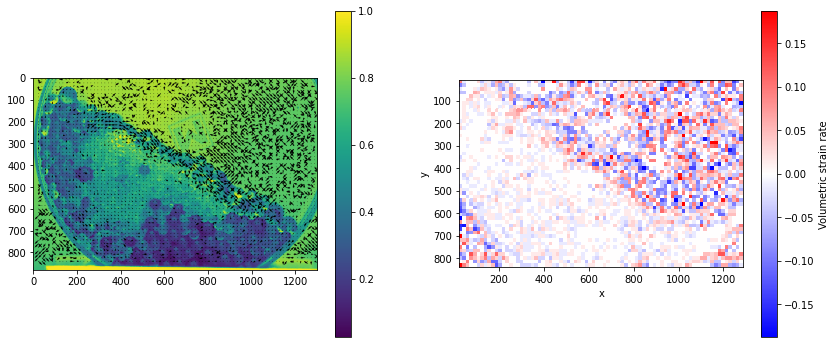

In [ ]:
# width of the patch
patch_width = 16
# spacing between grid points vertically
spacing_horiz = 1*patch_width
# spacing between grid points horizontally
spacing_vert = 1*patch_width
# search this many pixels left/right/up/down from the centre of the patch
max_search_range = 3

# size of the (cropped) source image
height, width = F_gray_cropped.shape

# list of pixels we want to search over in each patch
search_horizontal = np.arange(-max_search_range,max_search_range+1)
search_vertical   = np.arange(-max_search_range,max_search_range+1)

# list of top/left corner of patches that we want to investigate
grid_left = np.arange(patch_width,width -patch_width,spacing_horiz)
grid_top  = np.arange(patch_width,height-patch_width,spacing_vert)

# arrays to store final values in
displacement_x = np.zeros([len(grid_left), len(grid_top)])
displacement_y = np.zeros([len(grid_left), len(grid_top)])

# an array to store our eta values in, will be recalulated for each patch
eta = np.zeros([2*max_search_range+1,2*max_search_range+1])

# horizontal patch counter
i = 0
for left in grid_left:
    # vertical patch counter
    j = 0
    for top in grid_top:
        # get this patch
        F_patch = F_gray_cropped[top:top+patch_width,left:left+patch_width]
        # vertical pixel search counter
        v = 0
        for dx in search_horizontal:  
            # reset horizontal pixel search counter u for each row
            u = 0
            for dy in search_vertical:
                # move the patch up/down by a distance dy, note that positive is down
                this_top = top - dy
                # move the patch left/right by a distance dx
                this_left = left + dx
                # get this patch
                G_patch = G_gray_cropped[this_top:this_top+patch_width,
                                         this_left:this_left+patch_width]
                # calculate the sum of squared differences
                eta[u,v] = np.sum(np.square(F_patch - G_patch))
                # increment u by 1
                u += 1
            # increment v by 1
            v += 1

        # get the indices of the minima from eta
        min_v,min_u = np.unravel_index(eta.argmin(), eta.shape)
        # find the corresponding displacements and store them
        displacement_x[i,j] = search_horizontal[min_u]
        displacement_y[i,j] = search_vertical[min_v]

        j += 1
    i += 1

# calculate the spatial gradient of the velocity fields
du_dx, du_dy = np.gradient(displacement_x,spacing_horiz,spacing_vert)
dv_dx, dv_dy = np.gradient(displacement_y,spacing_horiz,spacing_vert)

# get out invariants
volumetric_strain_rate = (du_dx + dv_dy)/2.
shear_strain_rate = (du_dy + dv_dx)/2.

# make some plots on a nice big figure
plt.figure(figsize=[14,6])
plt.subplot(121)
# show the initial image
plt.imshow(F_gray_cropped)
plt.colorbar()
# overlay some arrows with the displacements we calculated at the patch centres
plt.quiver(grid_left+patch_width/2.,
           grid_top-patch_width/2.,
           displacement_x.T,
           displacement_y.T)
plt.subplot(122)
# also show the corresponding volumetric strain rates
plt.pcolormesh(grid_left+patch_width/2.,
               grid_top-patch_width/2.,
               volumetric_strain_rate.T,
               shading='auto',
               cmap='bwr',
               vmin = -max_search_range/spacing_horiz,
               vmax =  max_search_range/spacing_horiz
            )
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Volumetric strain rate')
# flip the y axis so that it is increasing downwards
plt.gca().invert_yaxis()
# make the axes have an equal aspect ratio so it looks like the image
plt.gca().set_aspect('equal')
plt.show()